<a href="https://colab.research.google.com/github/THANUJAJULURU/skillsanta/blob/main/Thanuja.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

from zipfile import ZipFile
file_name="/content/drive/MyDrive/sample data/Meander_HandPD.zip"
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Mounted at /content/drive
Done


In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=20

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "train1",
     seed=123,
    shuffle=True, # Whether to shuffle the data. Default: True. If set to False, sorts the data in alphanumeric order.
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 368 files belonging to 2 classes.


In [ ]:
class_names = dataset.class_names
print(class_names)

for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

['MeanderControl', 'MeanderPatients']
(32, 256, 256, 3)
[1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1]


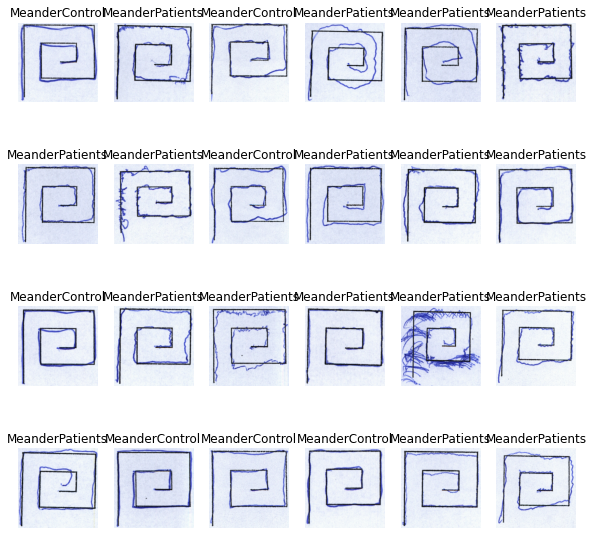

In [ ]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(24):
        ax = plt.subplot(4, 6, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [ ]:
len(dataset)
train_size = 0.8
len(dataset)*train_size
train_ds = dataset.take(9)
len(train_ds)

test_ds = dataset.skip(9)
len(test_ds)

val_size=0.1
len(dataset)*val_size

val_ds = test_ds.take(1)
len(val_ds)

test_ds = test_ds.skip(1)
len(test_ds)

2

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

9
1
2


In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [ ]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
compile avvaledu 
len(train_ds)

In [ ]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=20,
)

Epoch 1/20
9/9 [==============================] - 31s 3s/step - loss: 0.4777 - accuracy: 0.8199 - val_loss: 0.5136 - val_accuracy: 0.8125
Epoch 2/20
9/9 [==============================] - 31s 3s/step - loss: 0.4604 - accuracy: 0.8199 - val_loss: 0.4758 - val_accuracy: 0.8125
Epoch 3/20
9/9 [==============================] - 32s 3s/step - loss: 0.4501 - accuracy: 0.8199 - val_loss: 0.4604 - val_accuracy: 0.8125
Epoch 4/20
9/9 [==============================] - 33s 3s/step - loss: 0.4437 - accuracy: 0.8199 - val_loss: 0.4519 - val_accuracy: 0.8125
Epoch 5/20
9/9 [==============================] - 31s 3s/step - loss: 0.4195 - accuracy: 0.8199 - val_loss: 0.5569 - val_accuracy: 0.8125
Epoch 6/20
9/9 [==============================] - 31s 3s/step - loss: 0.4049 - accuracy: 0.8199 - val_loss: 0.6382 - val_accuracy: 0.8125
Epoch 7/20
9/9 [==============================] - 35s 4s/step - loss: 0.3983 - accuracy: 0.8199 - val_loss: 0.7207 - val_accuracy: 0.8125
Epoch 8/20
9/9 [==================

In [ ]:
scores = model.evaluate(test_ds)

2/2 [==============================] - 2s 905ms/step - loss: 0.4202 - accuracy: 0.8594


In [ ]:
scores

[0.4202216863632202, 0.859375]

In [ ]:
history

In [ ]:
history.params

{'epochs': 20, 'steps': 9, 'verbose': 1}

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
print(type(history.history['loss']))
len(history.history['loss'])

<class 'list'>


20

In [ ]:
history.history['loss'][:5] # show loss for first 5 epochs

[0.47766411304473877,
 0.4603781998157501,
 0.4501006603240967,
 0.4436592161655426,
 0.41948965191841125]

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [ ]:
EPOCHS=20

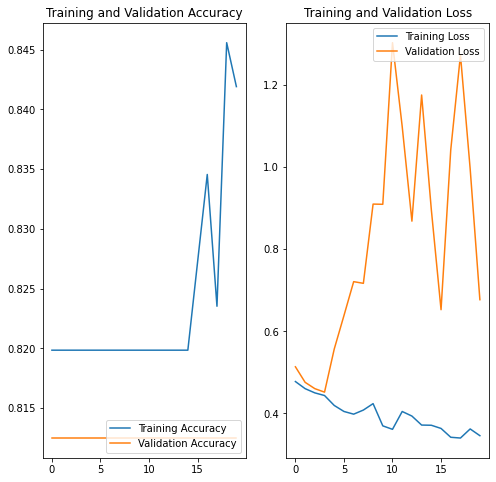

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


first image to predict
actual label: MeanderPatients
predicted label: MeanderPatients


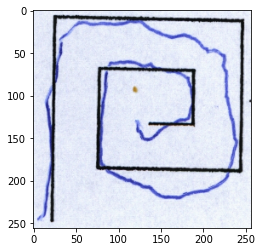

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

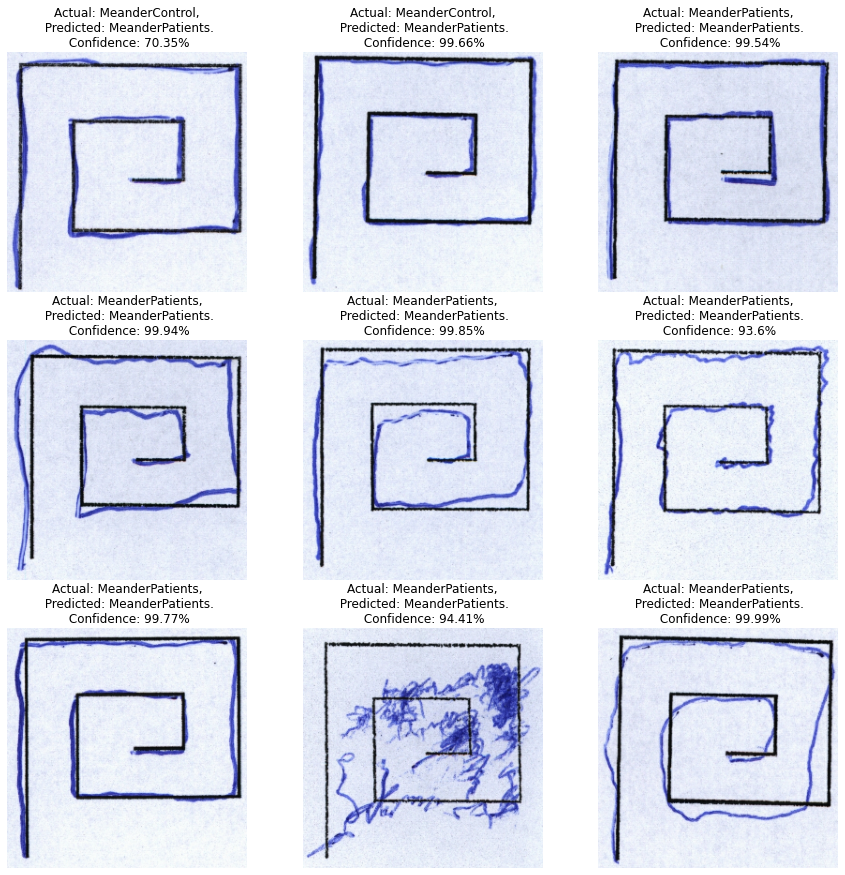

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")